# The FATE of FakeNews

## About the project

This project is a machine learning study based on the [fake news](https://www.kaggle.com/datasets/algord/fake-news/code) dataset and the interpertability of the machine learning model trained on said data. The goal of this work is to gain a deeper understanding of the chosen dataset and the WHYs regarding our model's "brain", in others words it's interpretability. My personal objective is to have a hands on approach in the field of FATE and better understand how to process data. 

Almost every data science paper talks about how we are living in the age of data abundance. We receive all kinds of information through our devices connected to the internet, such as: emails, weather forecasts, sleep metrics and the topic of my dataset, news. There is a sheer volume of news opinions from all sides made to fulfill every interest. While this can give us more insight, it can also provide us to information that may be misleading or outright false.

So, how can we tell if what we read is true? Well we could use machine learning to solve this issue. We should create a model based on a set of labeled data to tell whether a news article is real or fake. In doing so, we could also gain insights about the underlying patterns that writers use to gain more clicks or alter opinions by misleading their readers.

## Understanding our data

### Load the dataset, extract features and prepare data

Understanding the dataset is a crucial step in creating a good model.

First let's import a couple of packages and load in our dataset.

In [35]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Render figures inside the notebook
%matplotlib inline

In [36]:
# Load dataset using pandas
original_dataset = pd.read_csv('./data/FakeNewsNet.csv')
original_dataset

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


In [37]:
# Let's see the features we are working with
original_dataset.columns

Index(['title', 'news_url', 'source_domain', 'tweet_num', 'real'], dtype='object')

Printing out the features of our dataset we can see that there are 5 features:
- `title`: the title of the article (string)  
- `news_url`: direct url to the article (string)
- `source_domain`: the domain the article is published on (string)
- `tweet_num`: the number of retweets for this article (number)
- `real`: a binary value representing whether the article is fake or real, where 0 is fake and 1 is real (number)

I am also interested in the number of distinct values in the `title` and `real` columns.  
I want to make sure that a single `title` only exists once in my dataset (they are most likely mirrors that I don't want my model to train on multiple times).  

I also want to make sure that the `real` feature is truly binary (just a sanity check).  
(These properties can also be easily checked by using the [data wrangler](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.datawrangler) VSCode extension)

In [52]:
print('Number of datapoints: ', len(original_dataset))
print('---')
print('Number of unique titles: ', len(original_dataset['title'].unique()))
print('Number of non-unique titles: ', len(original_dataset['title'][original_dataset['title'].duplicated()]))
print('---')
print('Number of `real` values', len(original_dataset['real']))
print('Unique `real` values', original_dataset['real'].unique())

# Clean the dataset
original_dataset.drop_duplicates(subset='title', inplace=True)
original_dataset.dropna(subset='news_url', inplace=True)

Number of datapoints:  23196
---
Number of unique titles:  21724
Number of non-unique titles:  1472
---
Number of `real` values 23196
Unique `real` values [1 0]


We should scrape the content corresponding to a `news_url` and create a dataset with that information included. To do this I created a `scraper.py` script in the scraper directory (keep in mind that this will take a long time to run ~30 minutes for our 21k+ rows... but I will upload a smaller dataset split into seperate train, dev and test sets to the repository, the reason for this will become clear later)

This information will be stored as another feature by name `article_content`.

*Before this scraper ran I also removed the non-unique titles and any records that had an empty `source_url`.*

In [39]:
# Load in our content complete dataset
dataset = pd.read_csv('./data/FakeNewsNetWithArticleContent.csv')
dataset

,title,news_url,source_domain,tweet_num,real,article_content
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1,"It all hit the fan on the final ""Real Housewiv..."
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1,It was not a night for understatement!\n\nGlit...
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1,"""Breyton 4eva!""\n\nSophia Bush took to Instagr..."
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1,Online commentators have said their relationsh...
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1,[ERROR]
...,...,...,...,...,...,...
21392,See 'Love Actually' Sequel Clip for Red Nose D...,https://www.rollingstone.com/movies/movie-news...,www.rollingstone.com,0,1,A new trailer for the Love Actually short sequ...
21393,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1,We use your sign-up to provide content in ways...
21394,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0,[ERROR]
21395,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1,[ERROR]


We'll also need to clean this data, because the scaper couldn't find the content in all cases, so there are a lot of rows with the value "[ERROR]" and some have missing content. 
Let's check how many there are, filter those out, and see what data we're left with. This step is really only necessary if we want to focus on `article_content` (which we should, because that holds the most amount of information).

In [46]:
# Remove rows with invalid article content
dataset = dataset.dropna(subset='article_content', inplace=False)
dataset = dataset[dataset['article_content'] != '[ERROR]']
dataset


,title,news_url,source_domain,tweet_num,real,article_content
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1,"It all hit the fan on the final ""Real Housewiv..."
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1,It was not a night for understatement!\n\nGlit...
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1,"""Breyton 4eva!""\n\nSophia Bush took to Instagr..."
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1,Online commentators have said their relationsh...
6,Broward County Sheriff Fired For Lying About P...,https://yournewswire.com/broward-county-sherif...,yournewswire.com,124,0,Sports\n\nGET $750 IN BONUS FUNDS ON YOUR FIRS...
...,...,...,...,...,...,...
21389,NBC Investigation Finds No Wrongdoing in Handl...,https://www.nytimes.com/2018/05/09/business/me...,www.nytimes.com,49,1,An investigation by NBCUniversal’s legal team ...
21391,Becky G and Boyfriend Sebastian Lletget's Most...,https://people.com/chica/becky-g-sebastian-lle...,people.com,51,1,01 of 15 Instagram/ @iambeckyg Becky G is not ...
21392,See 'Love Actually' Sequel Clip for Red Nose D...,https://www.rollingstone.com/movies/movie-news...,www.rollingstone.com,0,1,A new trailer for the Love Actually short sequ...
21393,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1,We use your sign-up to provide content in ways...


In [47]:
dataset.shape

(12243, 6)

With every unwanted entry removed we have 12243 datapoints left. 

### Data visualization

First let's see how many real and fake entries we have in the cleaned dataset.

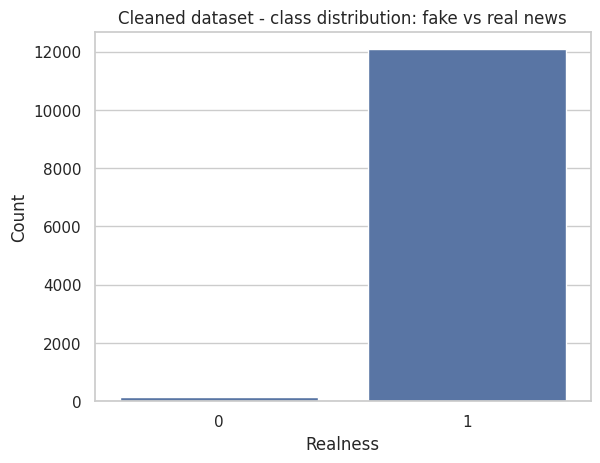

In [49]:
sns.countplot(data=dataset, x='real')
plt.title('Cleaned dataset - class distribution: fake vs real news')
plt.xlabel('Realness')
plt.ylabel('Count')
plt.show()

Uh oh, this is a problem, I was too strict when I cleaned the dataset and now there are barely any fake news left, 160 to be exact.

In [ ]:
len(dataset[dataset['real'] == 0])

160

What I am going to do now is that I will train two models:
- One model to determine fakeness by article titles
- The second to determine fakeness using the article content 
  
I will also slim down the dataset containing the articles contents, because it's too large and the ratio of real to fake data is too large, causing class imbalance which would in turn cause the model to be biased towards the majority class, incorrecly labeling more articles as real.   
Now I'll continue by visualizing the real to fake class distribution of the original dataset which has more data.

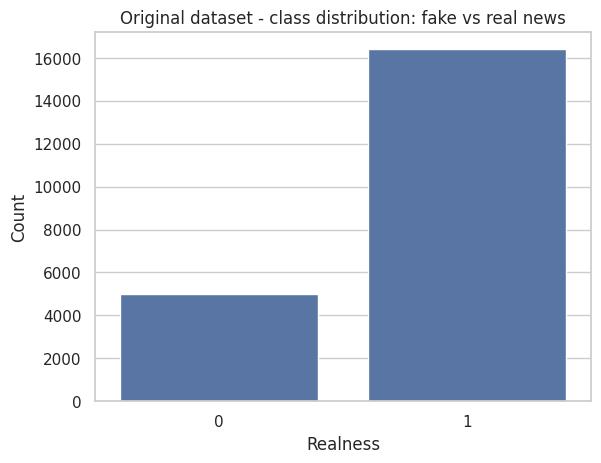

Real news:  16401
Fake news:  4996
Ratio:  3.282826261008807


In [59]:
sns.countplot(data=original_dataset, x='real')
plt.title('Original dataset - class distribution: fake vs real news')
plt.xlabel('Realness')
plt.ylabel('Count')
plt.show()

real_count = len(original_dataset[original_dataset['real'] == 1])
fake_count = len(original_dataset[original_dataset['real'] == 0])
print("Real news: ", real_count)
print("Fake news: ", fake_count)
print("Ratio: ", real_count / fake_count)

One might be interested in the distribution of different sources. 

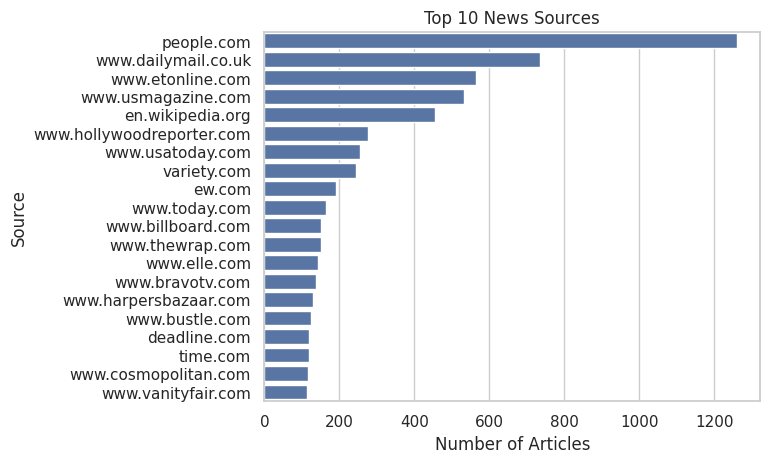

In [81]:
top_sources = dataset['source_domain'].value_counts().head(20)
sns.barplot(x=top_sources.values, y=top_sources.index)

plt.title('Top 10 News Sources')
plt.xlabel('Number of Articles')
plt.ylabel('Source')
plt.show()

Next let's generate separate word clouds for fake and real news titles and contents. This reveals the most frequent words and highlights language differences between fake and real news.

The most notable observation here is that fake news really loves to use a couple of celebrity names and repeat them ad nauseam. 

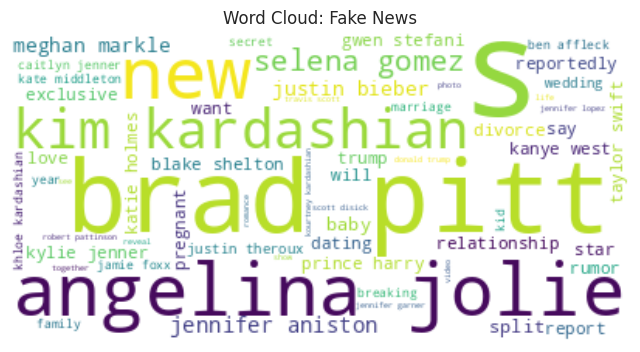

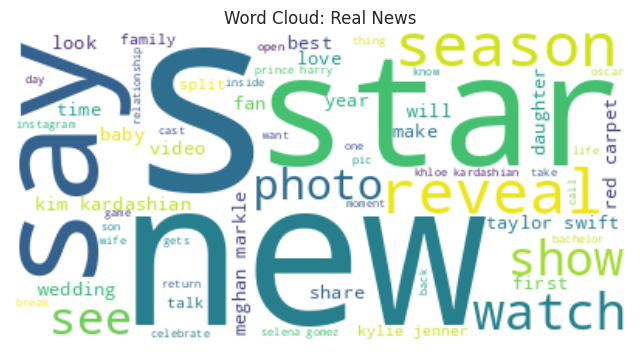

In [79]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Word cloud for fake news
fake_text = ' '.join(original_dataset[original_dataset['real'] == 0]['title']).lower()
fake_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=60).generate(fake_text)

plt.figure(figsize=(8,8))
plt.imshow(fake_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Fake News')
plt.show()

# Word cloud for real news
real_text = ' '.join(original_dataset[original_dataset['real'] == 1]['title']).lower()
real_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=60).generate(real_text)

plt.figure(figsize=(8,8))
plt.imshow(real_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Real News')
plt.show()

On these wordclouds we could actually plot the values from the `article_content` columns if we wanted to since they divide the data on the `real` feature.

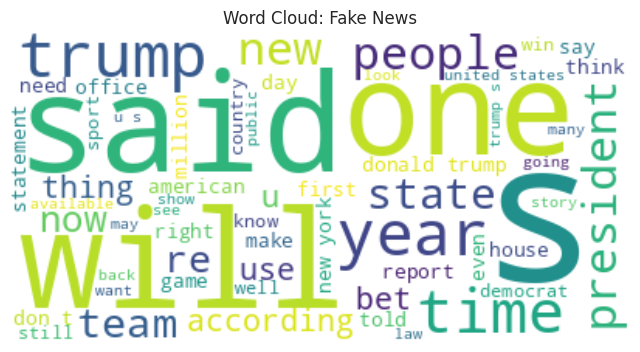

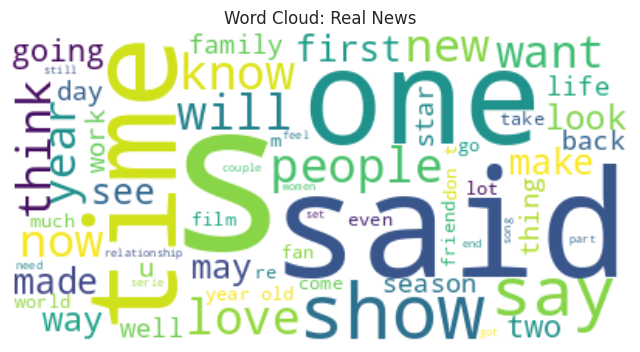

In [80]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Word cloud for fake news 
fake_text = ' '.join(dataset[dataset['real'] == 0]['article_content']).lower()
fake_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=60).generate(fake_text)

plt.figure(figsize=(8,8))
plt.imshow(fake_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Fake News')
plt.show()

# Word cloud for real news
real_text = ' '.join(dataset[dataset['real'] == 1]['article_content']).lower()
real_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=60).generate(real_text)

plt.figure(figsize=(8,8))
plt.imshow(real_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Real News')
plt.show()